# STA365: Applied Bayesian Statistics HW 9
---

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import pymc as pm
import arviz as az

## Question 1
### 1.2

In [3]:
df = pd.read_csv('housing.csv')
data = df[['median_income', 'median_house_value']].dropna()
data['median_house_value'] /= 1000


In [4]:
x_cdf = stats.norm.cdf(data['median_income'], loc=data['median_income'].mean(), scale=data['median_income'].std())
y_cdf = stats.norm.cdf(data['median_house_value'], loc=data['median_house_value'].mean(), scale=data['median_house_value'].std())
x_gauss = stats.norm.ppf(x_cdf)
y_gauss = stats.norm.ppf(y_cdf)

data_transformed = np.column_stack([x_gauss, y_gauss])

coords = {
    "param": ["income", "house_value"],
    "param_bis": ["income", "house_value"],
    "obs_id": np.arange(len(data_transformed))
}

with pm.Model(coords=coords) as copula_model:

    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=2,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("param", "param_bis"))

    pm.MvNormal("N", mu=0.0, cov=cov, observed=data_transformed, dims=("obs_id", "param"))

    idata = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 429 seconds.


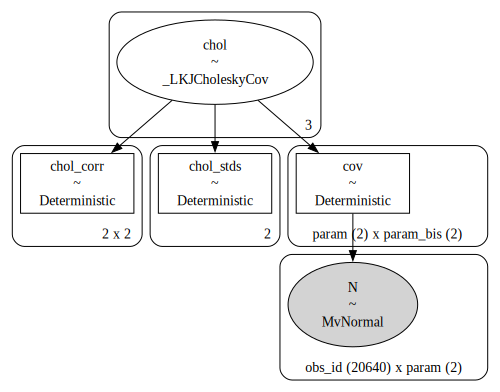

In [5]:
pm.model_graph.model_to_graphviz(copula_model)

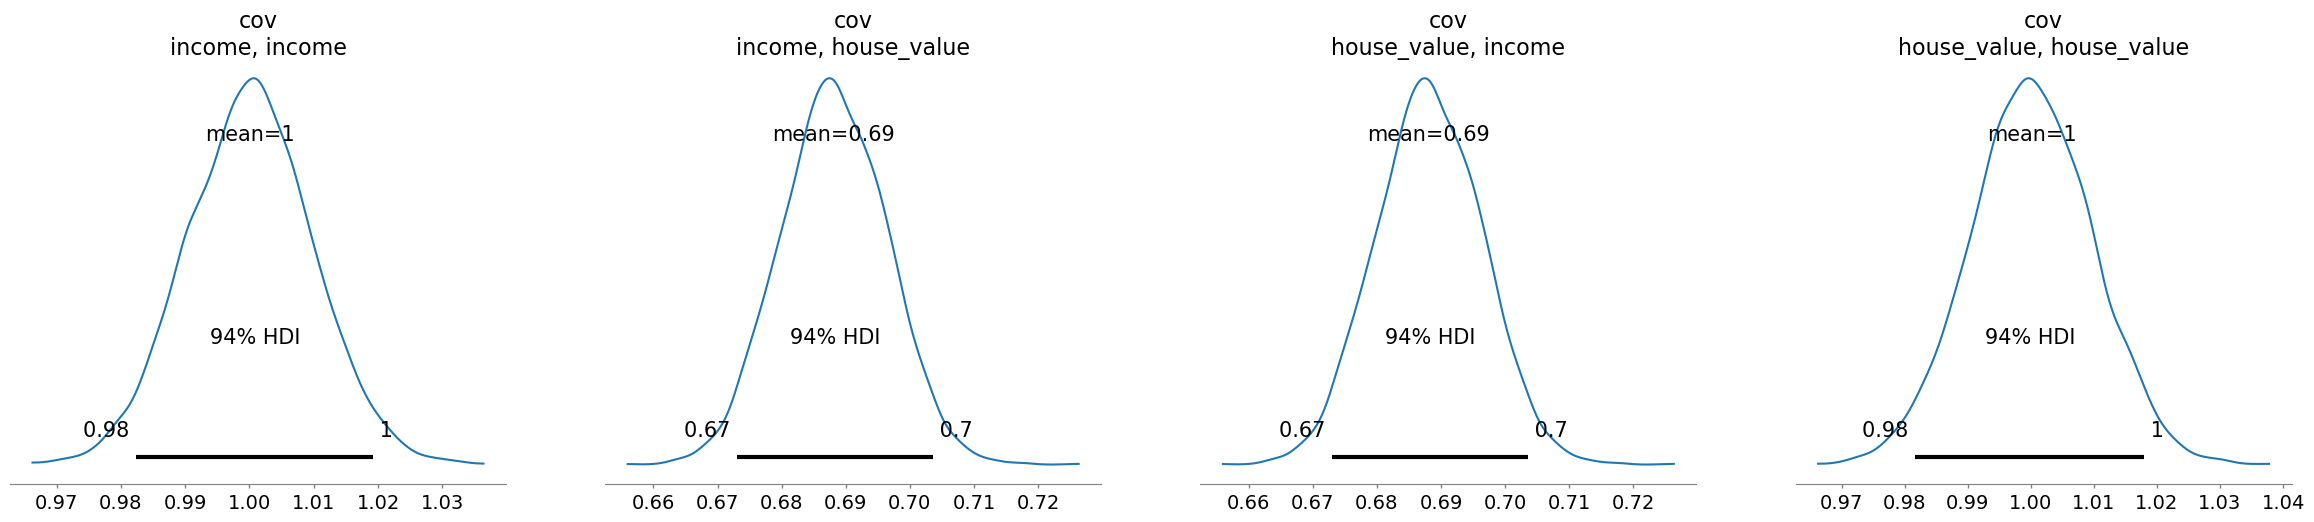

In [6]:
az.plot_posterior(idata, var_names=["cov"]);

### 1.3 
A copula is a function that models the dependence between random variables separately from their marginal distributions. Any multivariate distribution can be decomposed into its marginal distributions and a copula that captures their dependence.
### 1.4
A copula-based multivariate GLM models each response variable separately with an appropriate GLM, then transforms residuals to uniform space via the probability integral transform (PIT). A copula (e.g. Gaussian) captures dependencies between transformed variables, allowing flexible correlation modeling even with non-normal marginals. This approach enables joint modeling of responses like Poisson and Gamma while preserving their individual distributions.

## Question 2

In [ ]:
X = df[['latitude', 'longitude', 'median_income']].values
X = (X - X.mean(axis=0)) / X.std(axis=0)

Y = df[['median_house_value', 'population']].values
Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)

n, p = X.shape
m = Y.shape[1]

In [14]:
with pm.Model() as spike_slab_model:
    #Priors
    gamma = pm.Bernoulli("gamma", p=0.5, shape=(p, m))
    tau = pm.HalfNormal("tau", sigma=1, shape=(p, m))
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=(p, m)) * gamma

    #Likelihood
    mu = pm.math.dot(X, beta)
    sigma = pm.HalfNormal("sigma", sigma=1, shape=m)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
    #Sample
    idata_spike_slab = pm.sample(4000, tune=1000, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [gamma]
>NUTS: [tau, beta, sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 111 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 2408 divergences after tuning. Increase `target_accept` or reparameterize.


In [15]:
with pm.Model() as normal_prior_model:
    #Priors
    beta = pm.Normal("beta", mu=0, sigma=10, shape=(p, m))
    
    #Likelihood
    mu = pm.math.dot(X, beta)
    sigma = pm.HalfNormal("sigma", sigma=1, shape=m)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    #Sample
    idata_normal = pm.sample(4000, tune=1000, return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 49 seconds.


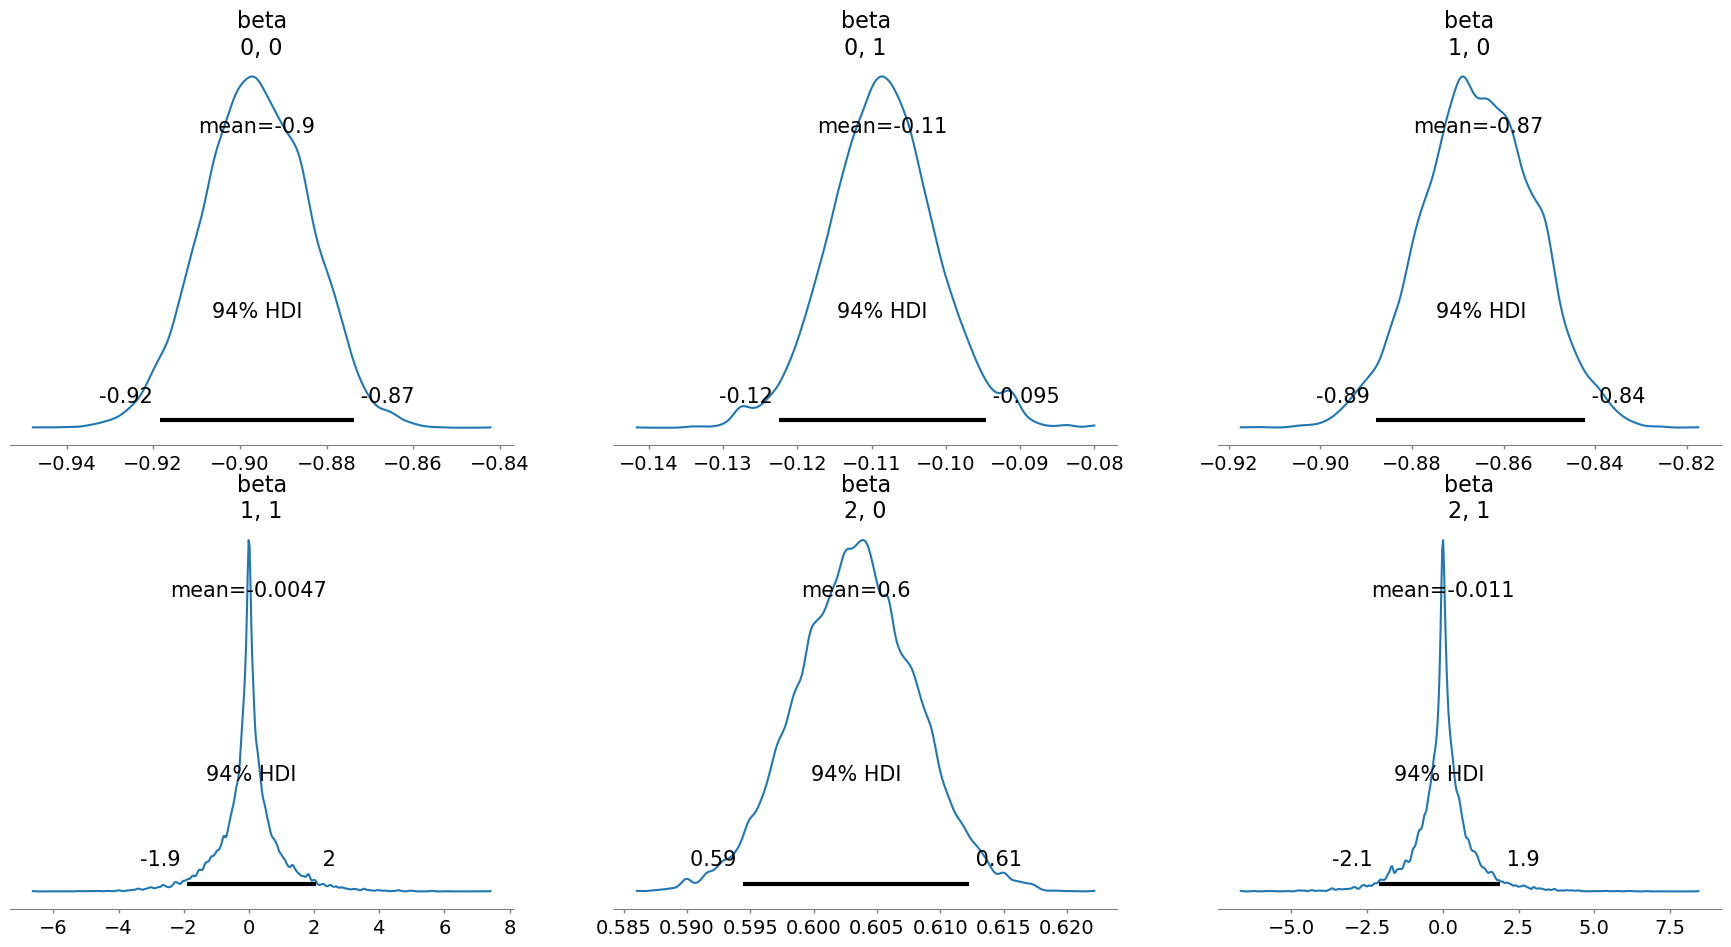

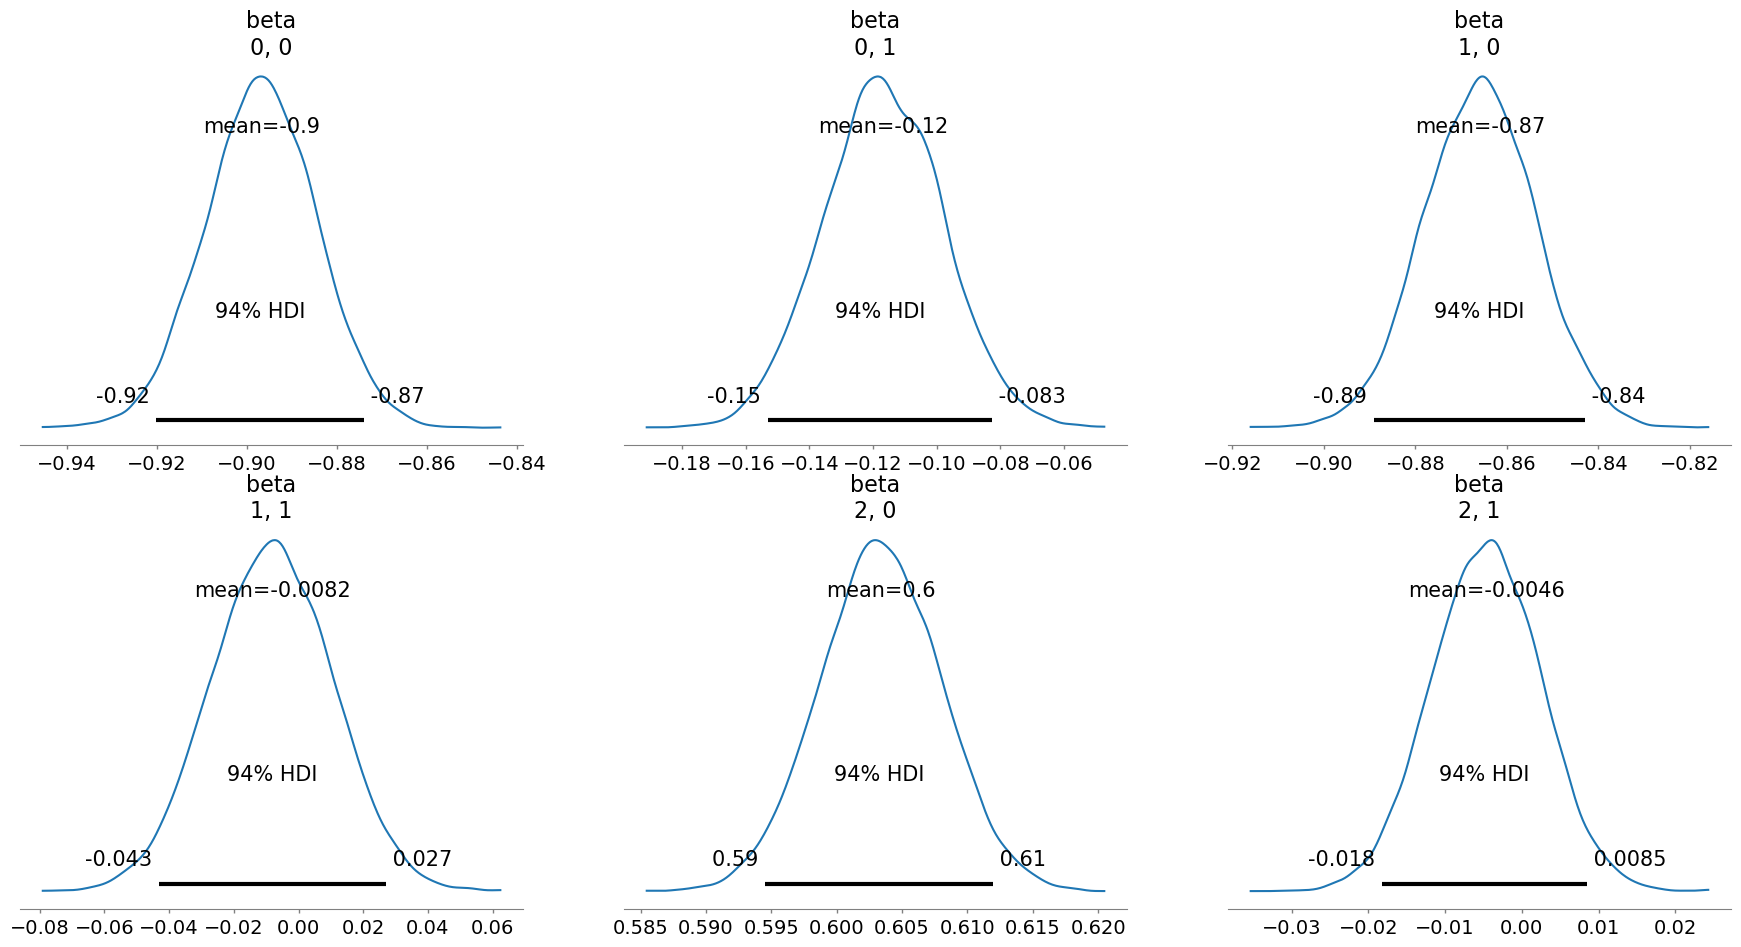

In [16]:
az.plot_posterior(idata_spike_slab, var_names=["beta"])
az.plot_posterior(idata_normal, var_names=["beta"])
plt.show()

- Very similar estimates, however spike and slab model for some beta narrows the confidence in the parameter estimate (i.e. beta 1,1 and beta 2,1, longitude-population and income-population)

## Question 3

In [23]:
with pm.Model() as horseshoe_model:
    #Priors
    tau = pm.HalfCauchy("tau", beta=1)
    lambda_ = pm.HalfCauchy("lambda", beta=1, shape=(p, m))
    beta = pm.Normal("beta", mu=0, sigma=tau * lambda_, shape=(p, m))

    #Likelihood
    mu = pm.math.dot(X, beta)
    sigma = pm.HalfNormal("sigma", sigma=1, shape=m)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    #Sample
    idata_horseshoe = pm.sample(6000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambda, beta, sigma]


Sampling 4 chains for 1_000 tune and 6_000 draw iterations (4_000 + 24_000 draws total) took 106 seconds.
There were 903 divergences after tuning. Increase `target_accept` or reparameterize.


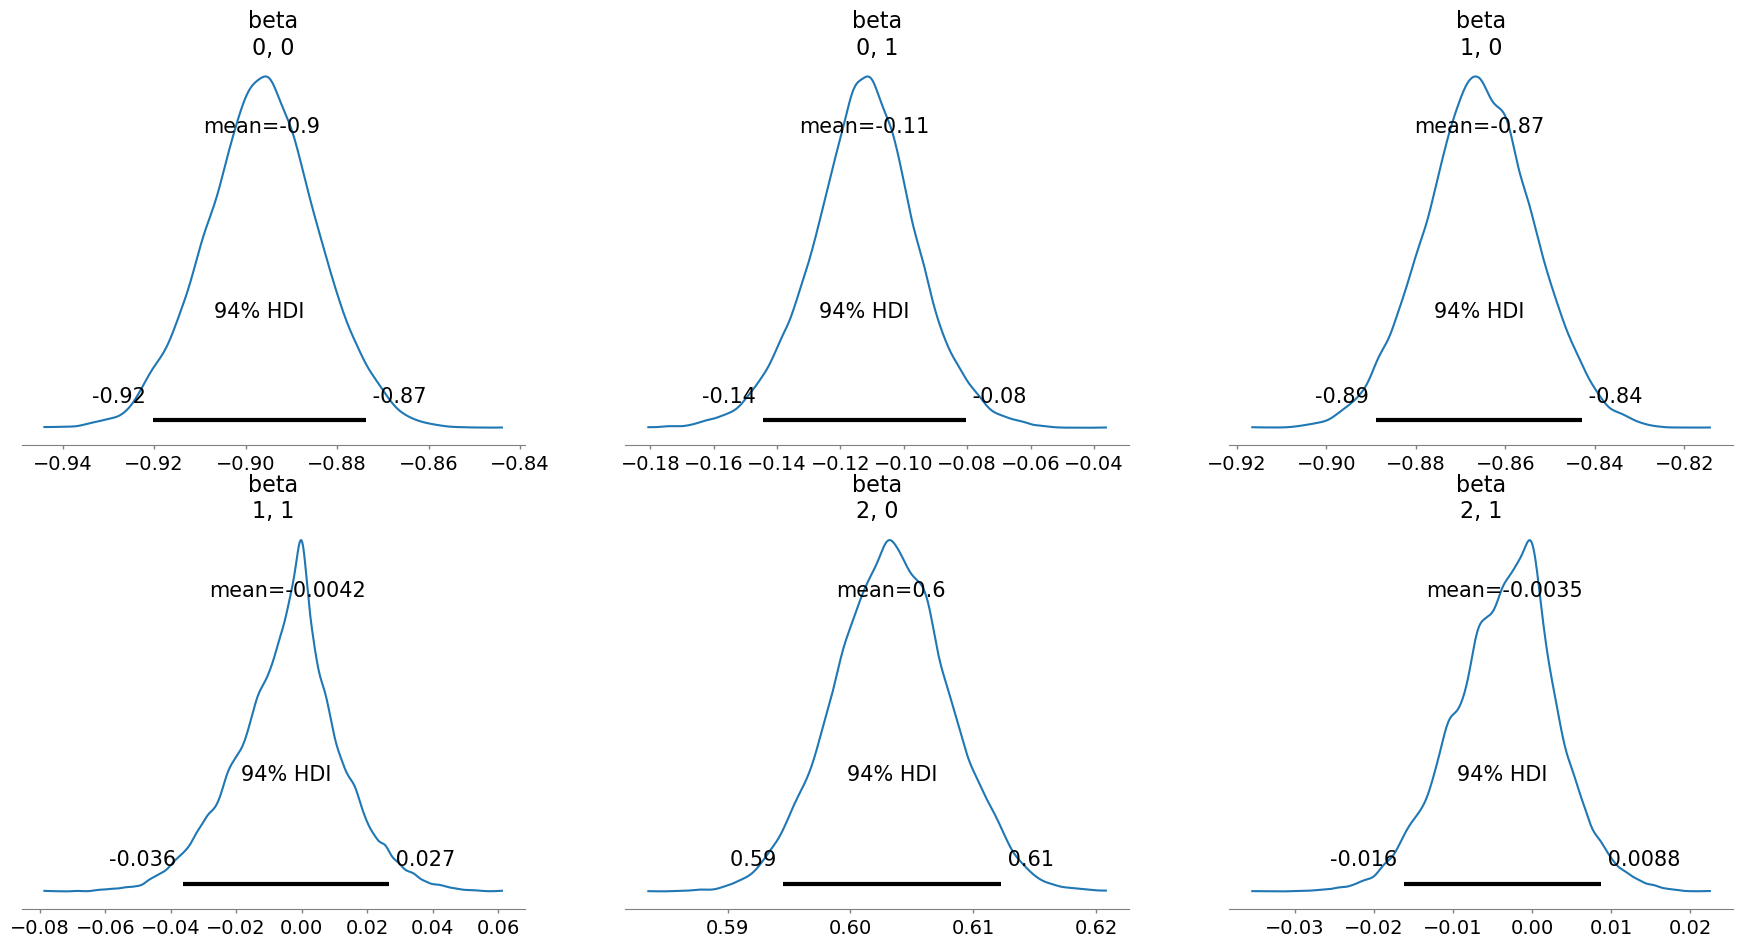

In [24]:
az.plot_posterior(idata_horseshoe, var_names=["beta"])
plt.show()

Compared to the spike and slab model...
- Very similar beta estimates
- Not as sharp of a peak in the beta distributions (less confidence)